In [1]:
import multiprocessing as mp
import numpy as np
import pandas as pd
from numba import njit, jit
import matplotlib.pyplot as plt
import seaborn as sb
import time
import pprint

from IPython.display import display
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Import own code
from default_constants import *
from algorithms import *
from signal_data_class import *
# from interactive_trigger_class import *
from plot_data import *

sb.set()
pp = pprint.PrettyPrinter(indent=4)

SN1 = "../data/SN1_Chirp_300kHzTemplate_0p16SNR_280Start_Sig.npy"  # Nasty noise
SN2 = "../data/SN2_Chirp_300kHzTemplate_0p32SNR_280Start_Sig.npy"  # Nice noise
SX1 = "../data/SX1_ChirpSig_ChirpTemplate_325p5kHz_3p45e8Grad_1024pt_99mV.npy"
SX2 = "../data/SX2_ChirpSig_ChirpTemplate_325p5kHz_3p45e8Grad_1024pt_132mV.npy"
SX3 = "../data/SX3_ChirpSig_ChirpTemplate_325p5kHz_3p45e8Grad_1024pt_264mV.npy"
XN1 = "../data/XN1_Chirp_300kHzTemplate_0p16SNR_280Start_Noise.npy"
XN2 = "../data/XN2_Chirp_300kHzTemplate_0p32SNR_280Start_Noise.npy"

data = {}
# data["SN1"] = np.array(list( zip(*np.load(SN1)) ))
# data["SN2"] = np.array(list( zip(*np.load(SN2)) ))
data["SX1"] = np.array(list( zip(*np.load(SX1)) ))
# data["SX2"] = np.array(list( zip(*np.load(SX2)) ))
# data["SX3"] = np.array(list( zip(*np.load(SX3)) ))
data["XN1"] = np.array(list( zip(*np.load(XN1)) ))
data["XN2"] = np.array(list( zip(*np.load(XN2)) ))


sample_spacing 1e-06
pulse_spacing 0.002 (2ms)

samples_per_chirp: 2000
samples: 1006484
chirp_no: 503.242
samples_trunc: 1006000
chirp_no_trunc: 503

mean: 1594


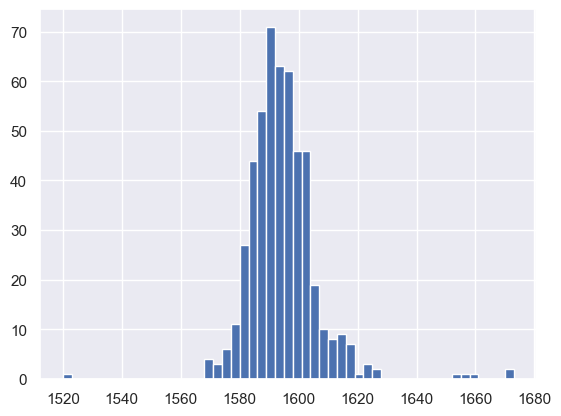

In [2]:
# Create truth data for SX1

# Find position of chirp per cycle

t = data["SX1"][0]
sig = data["SX1"][1]

sample_spacing = 1e-6
pulse_spacing = 2e-3  # 2ms
print("sample_spacing", sample_spacing)
print("pulse_spacing", pulse_spacing, "(2ms)")
print()

samples_per_chirp = int(pulse_spacing / sample_spacing)
samples = len(t)
chirp_no = samples / samples_per_chirp

print("samples_per_chirp:", samples_per_chirp)
print("samples:", samples)
print("chirp_no:", chirp_no)

samples_trunc = samples - (samples % samples_per_chirp)
chirp_no_trunc = samples_trunc // samples_per_chirp
print("samples_trunc:", samples_trunc)
print("chirp_no_trunc:", chirp_no_trunc)

t_trunc = t[:samples_trunc]
sig_trunc = sig[:samples_trunc]

chirp_sections = []
for i in range(chirp_no_trunc-1):
    section_start = samples_per_chirp * i
    section_end = samples_per_chirp * (i + 1)
    t_section = t[section_start:section_end]
    sig_section = sig[section_start:section_end]
    chirp_section = (t_section, sig_section)
    chirp_sections.append(chirp_section)

tops = []
for t_section, sig_section in chirp_sections:
    max_idx = np.argmax(sig_section)
    tops.append(max_idx)

print()
mean = int(np.mean((tops)))
print("mean:", mean)

fig, axis = plt.subplots()
axis.hist(tops, bins="auto")

# Create truth data
SX1_truth_data = np.zeros(1006484)
for i in range(chirp_no_trunc):
    idx_of_chirp = samples_per_chirp * i + mean
    SX1_truth_data[idx_of_chirp] = True


In [3]:
t1 = SignalData(data["SX1"],
                truth_data = SX1_truth_data,
                zero_detector_alg=zero_detector2,
                slice_start = 0,
                slice_end = 50000,
               )

inv_frac_vals = np.arange(1, 6, 0.5)
delay_samples_vals = np.arange(50, 250, 25)

start = time.time()
t1_all_test_params = t1.get_performance(inv_frac_vals = inv_frac_vals,
                                        delay_samples_vals = delay_samples_vals,
                                        tolerance = 100e-6,
                                        verbose = True,
                                       )
end = time.time()
print("Elapsed: ", end-start)


t1_pd = pd.DataFrame(t1_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t1_pd.to_csv("t1_performance_data.temp")


C:\Users\roysi\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\core\ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'x_all' of function 'LP_filt'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "algorithms.py", line 12:
# @make_typed
def LP_filt(x_all, DECAY_FULL_POWER=10, DECAY_PART=900):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


.......... 50
..........
.......... 75
..........
.......... 100
..........
.......... 125
..........
.......... 150
..........
.......... 175
..........
.......... 200
..........
.......... 225
..........
computation completed
Elapsed:  5.159130334854126


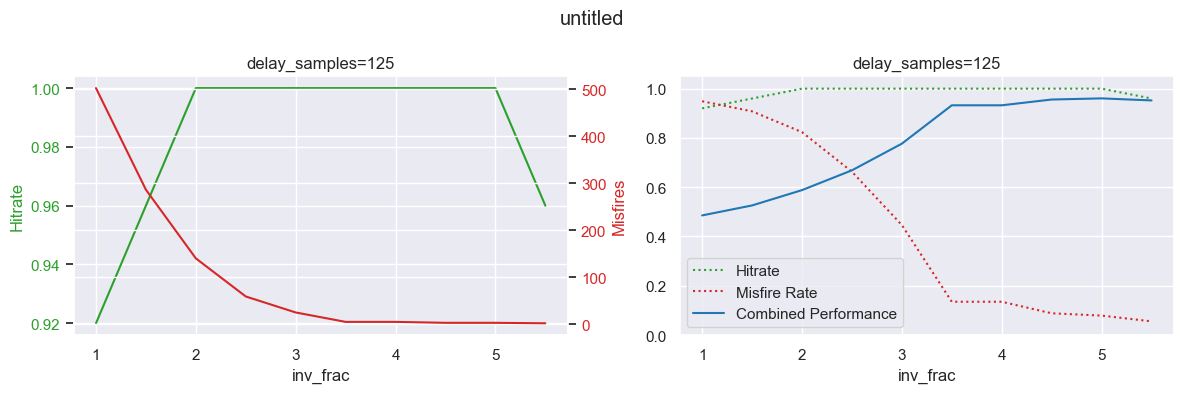

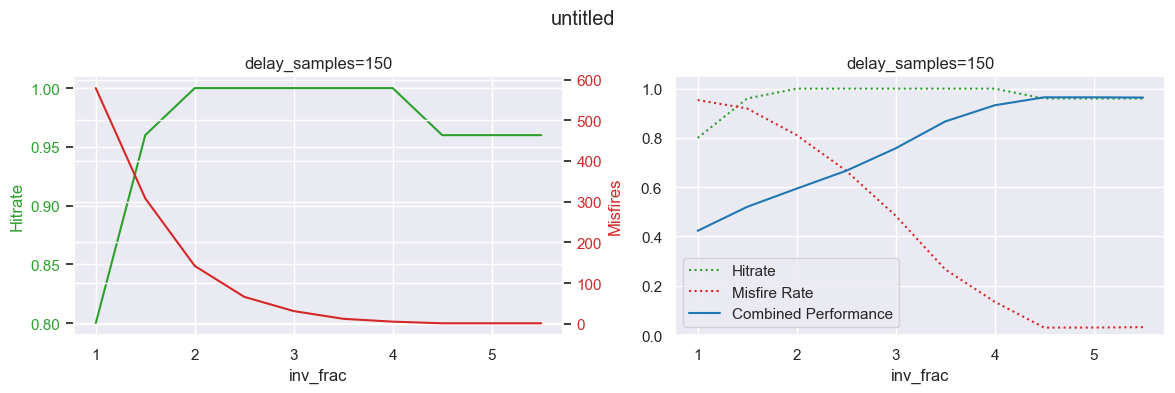

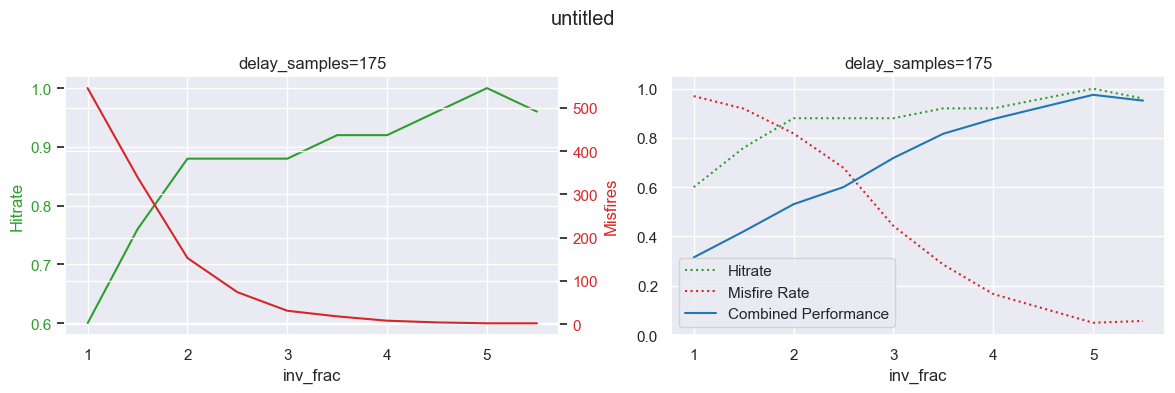

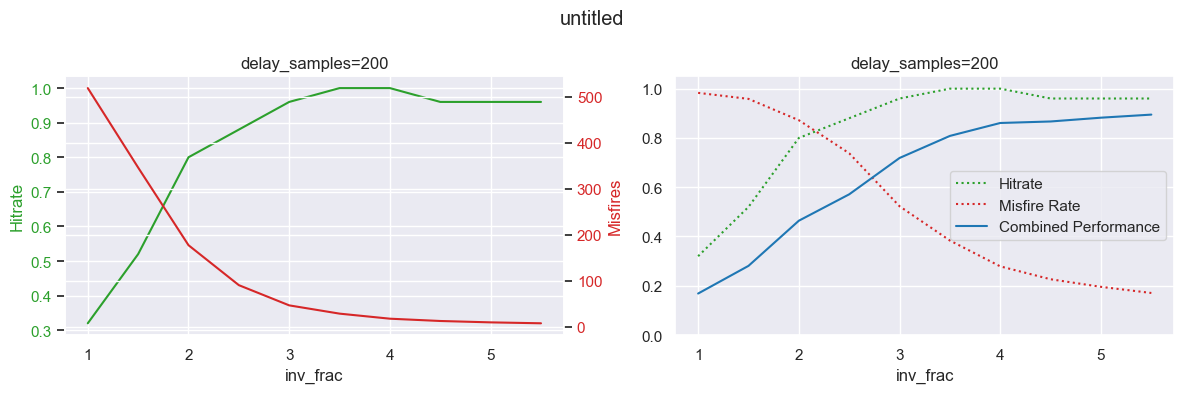

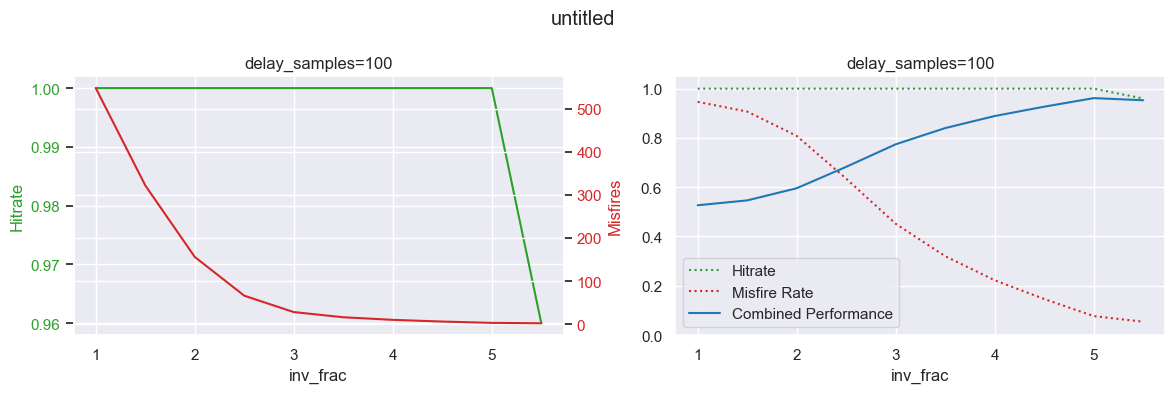

In [4]:
t1_pd_analyse = pd.read_csv("t1_performance_data.temp")

for ds in delay_samples_vals[3:7]:
    plot_inv_frac(t1_pd_analyse, delay_samples=ds)

plot_inv_frac(t1_pd_analyse)


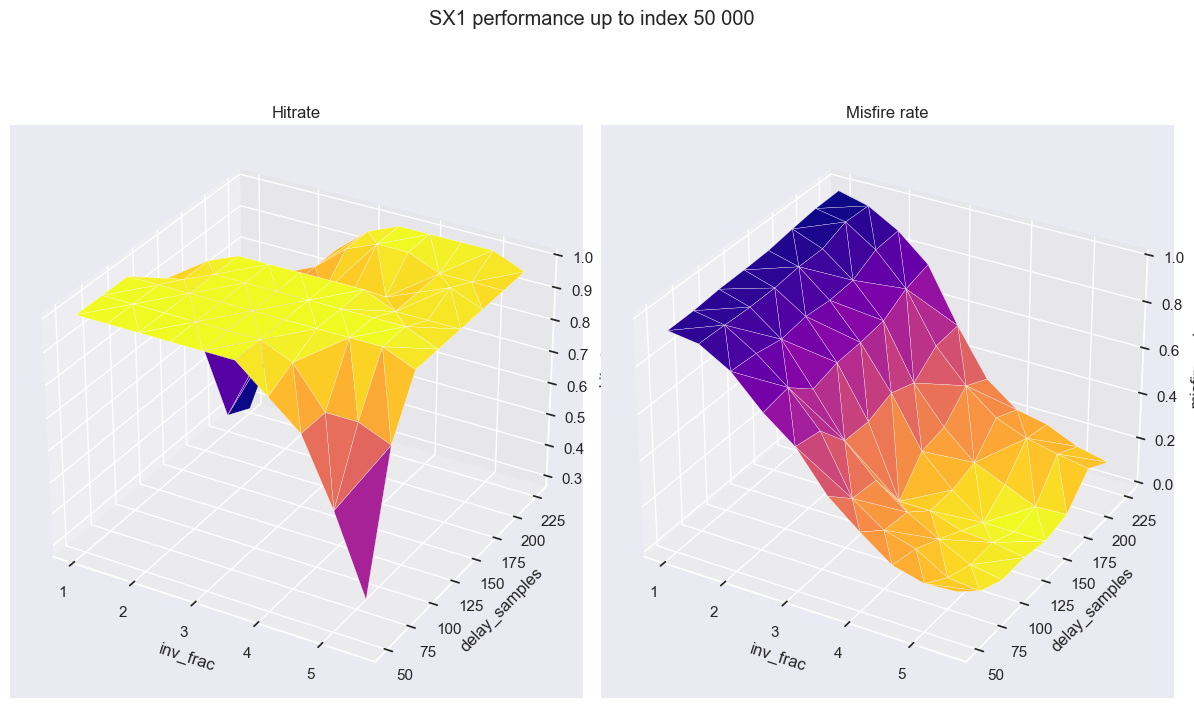

In [5]:
t1_pd_analyse = pd.read_csv("t1_performance_data.temp")
plot_all_3d(t1_pd_analyse, title="SX1 performance up to index 50 000")


In [6]:
# t2 = SignalData(data["SX1"], 
#                 truth_data = SX1_truth_data,
#                 zero_detector_alg=zero_detector2,
#                )

# inv_frac_vals = np.arange(2, 7 + 0.25, 0.25)  # Add step size to endpoint to include endpoint
# delay_samples_vals = np.arange(50, 350 + 15, 15)  # Add step size to endpoint to include endpoint

# start = time.time()
# t2_all_test_params = t2.get_performance(inv_frac_vals = inv_frac_vals,
#                                         delay_samples_vals = delay_samples_vals,
#                                         tolerance = 100e-6,
#                                         verbose = True,
#                                        )
# end = time.time()
# print("Elapsed (with compilation) = %s" % (end - start))

# t2_pd = pd.DataFrame(t2_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
# t2_pd.to_csv("t2_performance_data.temp")


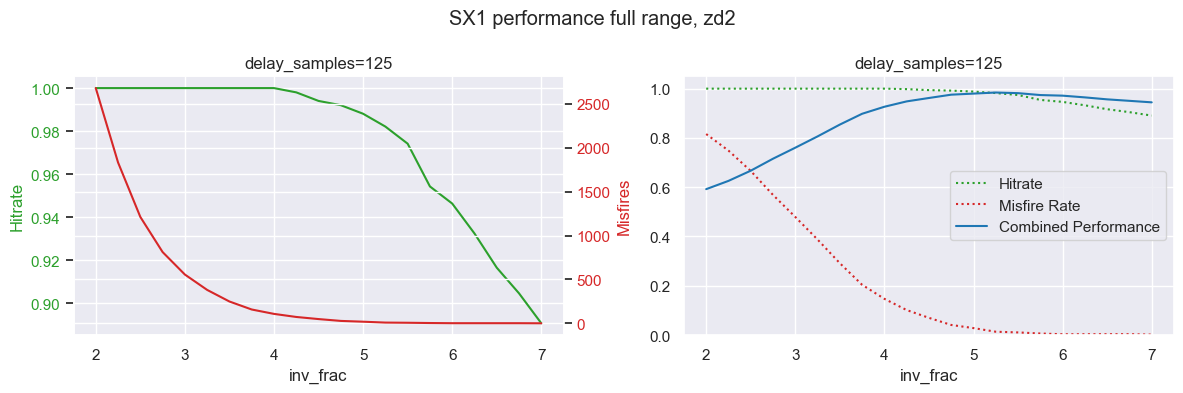

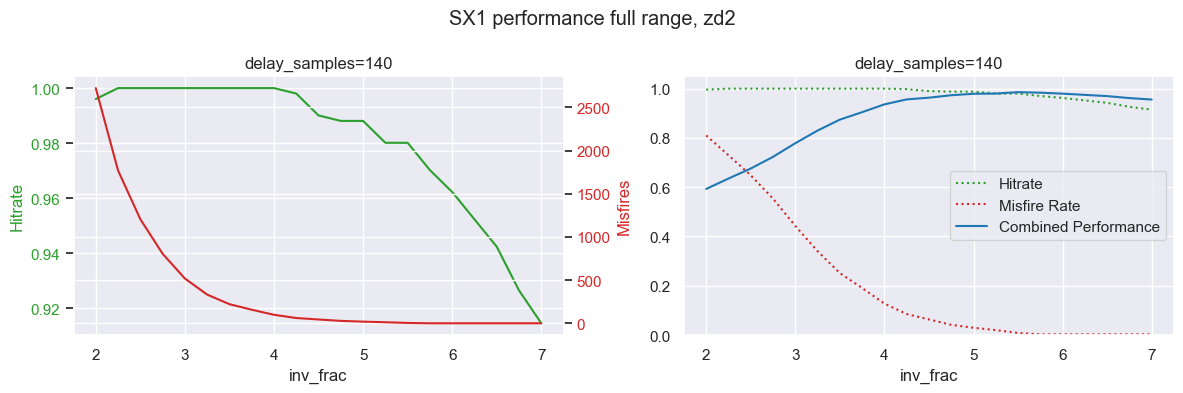

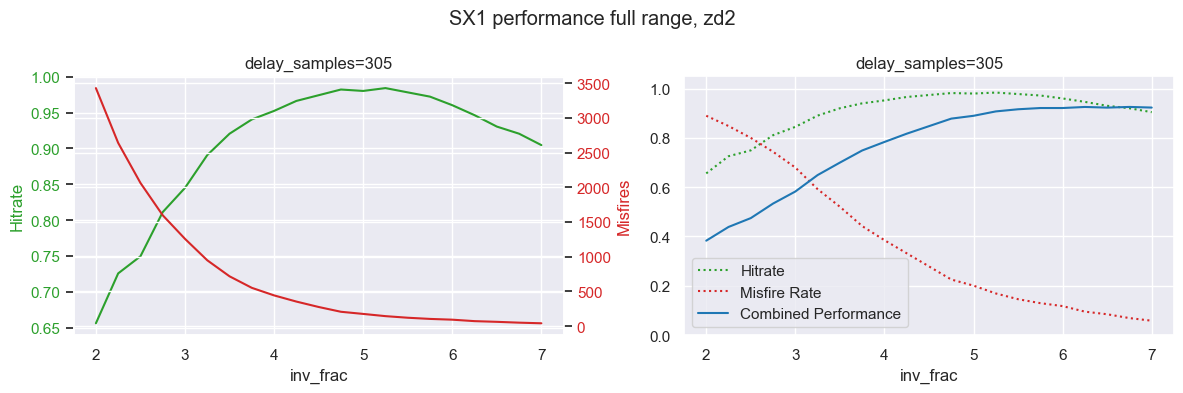

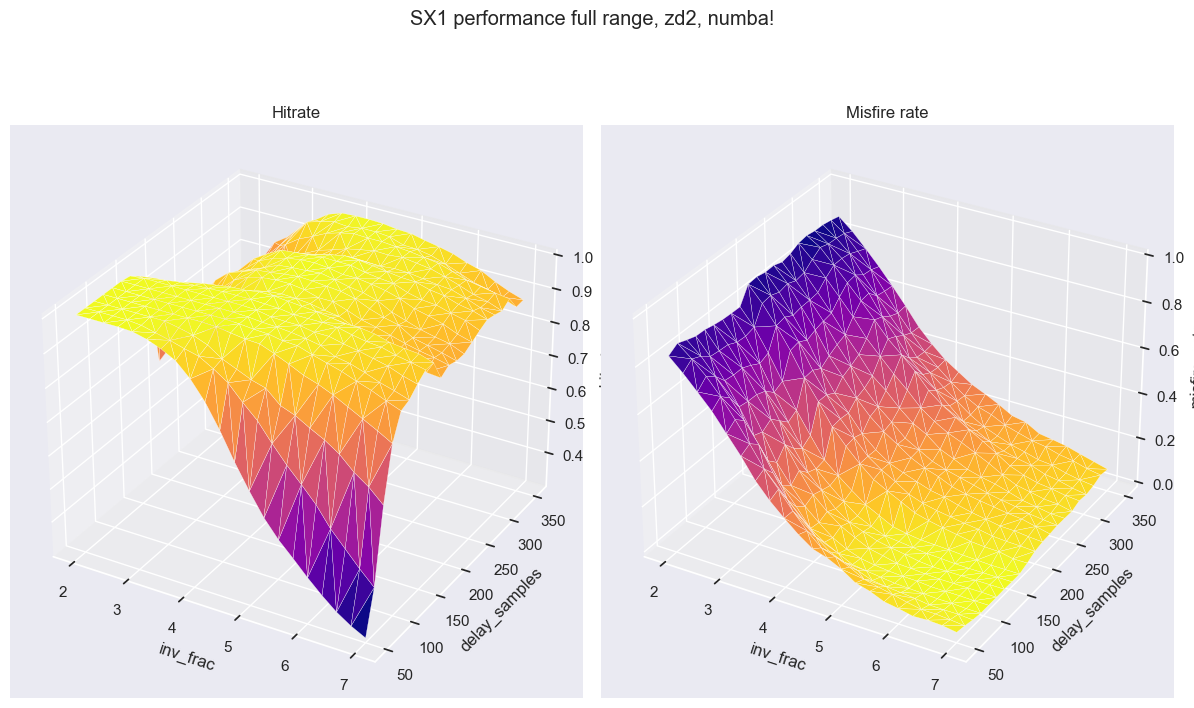

In [7]:
t2_pd_analyse = pd.read_csv("t2_performance_data.temp")

plot_inv_frac(t2_pd_analyse, delay_samples=125, title="SX1 performance full range, zd2")
plot_inv_frac(t2_pd_analyse, delay_samples=140, title="SX1 performance full range, zd2")
plot_inv_frac(t2_pd_analyse, delay_samples=305, title="SX1 performance full range, zd2")
plot_all_3d(t2_pd_analyse, title="SX1 performance full range, zd2, numba!")


In [8]:
# Make sig + noise, SX1+XN1, using SX1 truth data

SX1_t, SX1_sig = data["SX1"]
XN1_t, XN1_sig = data["XN1"]

print("len(SX1_t):", len(SX1_t))
print("len(XN1_t):", len(XN1_t))
trim = min(len(SX1_t), len(XN1_t))
SX1_sig = np.array(SX1_sig[:trim])
XN1_sig = np.array(XN1_sig[:trim])
print(f"Is time series (trimmed to [:{trim}]) of SX1 & XN1 the same?:", SX1_sig == XN1_sig)

combo_t = SX1_t[:trim]
combo_sig = SX1_sig + XN1_sig

data["SX1+XN1"] = [combo_t, combo_sig]


len(SX1_t): 1006484
len(XN1_t): 3010216
Is time series (trimmed to [:1006484]) of SX1 & XN1 the same?: [False False False ... False False False]


In [9]:
# image2 = InteractiveTrigger(
#         data["SX1+XN1"],
#         slice_start=0,
#         slice_end=3000,
#         zero_detector_alg=zero_detector2,
#     )

# interact(image2.update,
#       delay_samples=widgets.IntSlider(min=0, max=300, step=1, value=DELAY_SAMPLES), 
#       inv_frac=widgets.FloatSlider(min=0, max=6, step=0.1, value=INV_FRAC)
#     )


In [ ]:
t3 = SignalData(data["SX1+XN1"], 
                truth_data = SX1_truth_data,
                zero_detector_alg=zero_detector2,
               )

inv_frac_vals = np.arange(2, 7 + 0.25, 0.25)  # Add step size to endpoint to include endpoint
delay_samples_vals = np.arange(50, 350 + 15, 15)  # Add step size to endpoint to include endpoint

start = time.time()
t3_all_test_params = t3.get_performance(inv_frac_vals = inv_frac_vals,
                                        delay_samples_vals = delay_samples_vals,
                                        tolerance = 100e-6,
                                        verbose = True,
                                       )
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

t3_pd = pd.DataFrame(t3_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t3_pd.to_csv("t3_performance_data.temp")


..................... 50
.....................
..................... 65
.....................
..................... 80
.....................
..................... 95
.....................
..................... 110
.....................
..................... 125
.....................
..................... 140
.....................
..................... 155
.....................
..................... 170
.....................
..................... 185
.....................
..................... 200
.....................
..................... 215
.....................
..................... 230
.....................
..................... 245
.....................
..................... 260
.....................
..................... 275
....